# Noise_correlation 

Goal : This Notebook will generate plots allowing to perform a diagnostic on the noise ( noise level and correlation between channels ) .

Author : P.Antilogus

Version : 21 Feb 2019



In [1]:
# CONFIGURATION FOR THE CURRENT EXECUTION  ========================================
# ---- raft and associated run ============ To be updated if needed 
# 'RTM' :  full RTM name 
# 'Data_location'  :  0 = BNL_RAFT_ROOT ,  1 = SLAC_RAFT_ROOT 
# 'run' :  list of run , ex : ['9876','9874']  (remark : run is a string )   for all run of this raft : '*' 
# 'sensor' :  list of sensor , ex ['S00','S01','S02']  ,  for all sensor ['S*']
# amplifier : list of amplifier , ex [1,2]  , for 1 to 16 you can use [-1] instead 
data_to_select={'RTM':'RTM-013','Data_location':0,'run':['6543','6719','6807','6808','6809']}
#data_to_select={'RTM':'RTM-011-Dev','Data_location':2,'run':['5*']}
#data_to_select={'RTM':'RTM-013','Data_location':0,'run':['6543','6719','6807','6808','6809']}
# bias can be taken from # process , don't use the one with light , it makes bias "unstable" 
# good option are 'dark_raft_acq' or 'fe55_raft_acq' , only 1 bias per run and sensor will be used
bias_dir='fe55_raft_acq'
# Do you want the noise in ADU or e- ( for e- the eotest DB should be used - soft installed )
display_in_electron=True

In [2]:
# 0) the list of super flat for a raft - run : BNL_RAFT_ROOT+raft+'/'+run+'/cte_raft/*/*/'+'Sxx'+'/*_superflat_high.fits' 
BNL_RAFT_ROOT='/nfs/farm/g/lsst/u1/mirror/BNL-prod/prod/LCA-11021_RTM/LCA-11021_'
# 1)
SLAC_RAFT_ROOT='/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_'
# 2) Remark the raft name in general have a -Dev attahed to them for this SLAC dev sample 
BNL_DEV_RAFT_ROOT='/nfs/farm/g/lsst/u1/mirror/BNL-test/test/LCA-11021_RTM/LCA-11021_'
# 3) 
SLAC_DEV_RAFT_ROOT='/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/LCA-11021_RTM/LCA-11021_'
# other can be used if needed (including NCSA directory ) , 
# then just the order in which they are added to RAFT_ROOT should follow what will be given to 'data_location' 
ROOT=[BNL_RAFT_ROOT,SLAC_RAFT_ROOT,BNL_DEV_RAFT_ROOT,SLAC_DEV_RAFT_ROOT]
# For each directory tree in which part of the eotest DB can we get the associated data ( used for the gain )
DB_key=['Prod','Prod','Dev','Dev']

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pyfits
import time
from sys import exit 
if display_in_electron :
    try : 
        from get_EO_analysis_results import get_EO_analysis_results
        from get_EO_analysis_files import get_EO_analysis_files
        from exploreFocalPlane import exploreFocalPlane
        from exploreRaft import exploreRaft
        from eTraveler.clientAPI.connection import Connection
        g = get_EO_analysis_results(db=DB_key[data_to_select['Data_location']])
        eotest_db=True
    except:
        print('No access to eotest DB , so the gain of all devices will be set to 1 ( 1 ADU counted as 1 e- )')
        eotest_db=False
else :
    eotest_db=False
%run -i  ~/LSST/work/soft/ccd_ana/py/frame_study.py
get_ipython().magic('matplotlib inline')

In [4]:
# how many run & sensor 
sensor_dir=[]
run_loc=[]
# get all directory  for all sensor and all run 
for run_cur in data_to_select['run'] :
    sensor_cur='S*' 
    root_dir=ROOT[data_to_select['Data_location']]+data_to_select['RTM']+'/'+run_cur+'/'+bias_dir+'/v0/*/'+sensor_cur
    run_loc+=glob.glob(root_dir)
# order them all 
run_loc.sort()
# filter : keep only 1 proceesing for a given run and sensor (the first seen )
run_name_list=[]
sensor_list=[]
sensor_all=[]
sensor_dir=[]
for run_cur in run_loc :
    name_list=run_cur.split('/')
    run_number=name_list[-5]
    if not(run_number in run_name_list ) :
        # new run , let see which sensor are in it 
        run_name_list.append(run_number)
        if len(sensor_all) > len(sensor_list) :
            sensor_list=sensor_all
        sensor_all=[]
    sensor_name=name_list[-1]
    if not(sensor_name in sensor_all) :
        sensor_all.append(sensor_name)
        # we keep the first processed data for this run and sensor
        sensor_dir.append({'dir':run_cur,'run':run_number,'sensor':sensor_name})
if len(sensor_all) > len(sensor_list) :
    sensor_list=sensor_all
sensor_list.sort()    
#
number_of_run=len(run_name_list)
number_of_sensor=len(sensor_list)
#
if number_of_run < 1 : 
    print('No data found for ',data_to_select)
    raise 
#
# It does only makes sens if 9 CCD per raft have been selected
if number_of_sensor !=9 : 
    print('This code works only for the full set of sensors (=9) ...simple change could fix this ... ')
    raise
#
print('Noise study for ',number_of_run,' run(s) (',run_name_list,') from the raft ',data_to_select['RTM'])
#how many amplifiers 
amplifier_list=np.array(range(1,17))
amplifier_list.sort()
number_of_amplifier=len(amplifier_list)
print('For the 16 amplifiers of ',number_of_sensor,' sensors (',sensor_list,')')


Noise study for  5  run(s) ( ['6543', '6719', '6807', '6808', '6809'] ) from the raft  RTM-013
For the 16 amplifiers of  9  sensors ( ['S00', 'S01', 'S02', 'S10', 'S11', 'S12', 'S20', 'S21', 'S22'] )


In [5]:
# Open the files  and compute the noise per image
# intialisation 
noise=np.zeros((number_of_run,number_of_sensor*16)) 
noise_std=np.zeros((number_of_run,number_of_sensor*16)) 
all_file=np.zeros((number_of_run,number_of_sensor),dtype=np.object_)
mean_over=np.zeros((number_of_run,144),dtype=np.object_)
gain=np.ones((number_of_run,number_of_sensor,16))
#
for dir_cur in sensor_dir : 
    irun=run_name_list.index(dir_cur['run'])
    #
    iccd=sensor_list.index(dir_cur['sensor'])
    #
    if eotest_db : 
        raft_list, data = g.get_tests(site_type="I&T-Raft", test_type="gain", run =run_name_list[irun])  # get the data for I&T-Raft
        res = g.get_results(test_type='gain', data=data, device=raft_list[0])  # get the data for a raft
        # get the gain for the current sensor :
        sensor_id=[]
        for d in data['steps']['fe55_raft_analysis']['fe55_raft_analysis']:
            if 'slot' in d.keys():
                if d['slot']==sensor_list[iccd]:
                    sensor_id=d['sensor_id']
        if len(sensor_id)>0 :
            all_gain=np.array(res[sensor_id])
            # protection against badly measured gain : we accept only a gain within 15% of the median
            medgain=np.median(all_gain)
            if medgain < 0.5 : 
                # sensor not operational or what ? 
                print('Gain found in eotest for this sensor looks bad (median gain= %4.2f), sensor dead  ? We set all gain to 1 ' % (medgain))
            else : 
                for igain in range(len(all_gain)):
                    if np.abs(all_gain[igain]-medgain)>.2 :
                        print('Gain channel %02d found out of range  (=%4.2f) Channel could be dead or its a bad measurement . We set it to the median gain (=%4.2f) ' % (igain+1,all_gain[igain],medgain))
                        all_gain[igain]=medgain 
                gain[irun,iccd,:]=all_gain
            print('run =',run_name_list[irun],' sensor =',sensor_list[iccd],'=>',sensor_id,' (median gain=%4.2f)' % (medgain)) 
    else :
        print('run =',run_name_list[irun])
    #
    file_list=glob.glob(dir_cur['dir']+'/*bias*.fits')
    file_list.sort()
    nb_bias=len(file_list) 
    if nb_bias < 1 : 
        print (data_to_select['RTM']+':'+sensor_list[iccd]+' no bias found')
        continue
        #
    file_cur=pyfits.open(file_list[0])
    all_file[irun,iccd]=np.copy(file_cur)
    if irun==0 : 
        first_line,first_p_over,first_col,first_s_over=image_area(file_cur)
        ncol=len(file_cur[1].data[100,:])
    for ch in range(16) :
        noise[irun,iccd*16+ch]=(file_cur[ch+1].data[100:1900,first_s_over+2:].std(axis=1)).mean()*gain[irun,iccd,ch]
        noise_std[irun,iccd*16+ch]=(file_cur[ch+1].data[100:1900,first_s_over+2:].std(axis=1)).std()*gain[irun,iccd,ch]/np.sqrt(1800)
    #

run = 6543  sensor = S00 => ITL-3800C-269  (median gain=0.92)
run = 6543  sensor = S01 => ITL-3800C-261  (median gain=0.92)
run = 6543  sensor = S02 => ITL-3800C-205  (median gain=0.92)
run = 6543  sensor = S10 => ITL-3800C-160  (median gain=0.87)
run = 6543  sensor = S11 => ITL-3800C-244  (median gain=0.88)
run = 6543  sensor = S12 => ITL-3800C-157  (median gain=0.88)
run = 6543  sensor = S20 => ITL-3800C-156  (median gain=0.89)
Gain channel 05 found out of range  (=0.00) Channel could be dead or its a bad measurement . We set it to the median gain (=0.91) 
run = 6543  sensor = S21 => ITL-3800C-318  (median gain=0.91)
run = 6543  sensor = S22 => ITL-3800C-214  (median gain=0.91)
run = 6719  sensor = S00 => ITL-3800C-269  (median gain=0.91)
run = 6719  sensor = S01 => ITL-3800C-261  (median gain=0.92)
run = 6719  sensor = S02 => ITL-3800C-205  (median gain=0.91)
run = 6719  sensor = S10 => ITL-3800C-160  (median gain=0.87)
run = 6719  sensor = S11 => ITL-3800C-244  (median gain=0.88)
r

Computing correlations for run  6543
Computing correlations for run  6719 ~ 301  seconds left before the end of the processing of all the runs
Computing correlations for run  6807 ~ 226  seconds left before the end of the processing of all the runs
Computing correlations for run  6808 ~ 150  seconds left before the end of the processing of all the runs
Computing correlations for run  6809 ~ 75  seconds left before the end of the processing of all the runs


/nfs/farm/g/lsst/u1/software/redhat6-x86_64-64bit-gcc44/anaconda/5.2.0/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


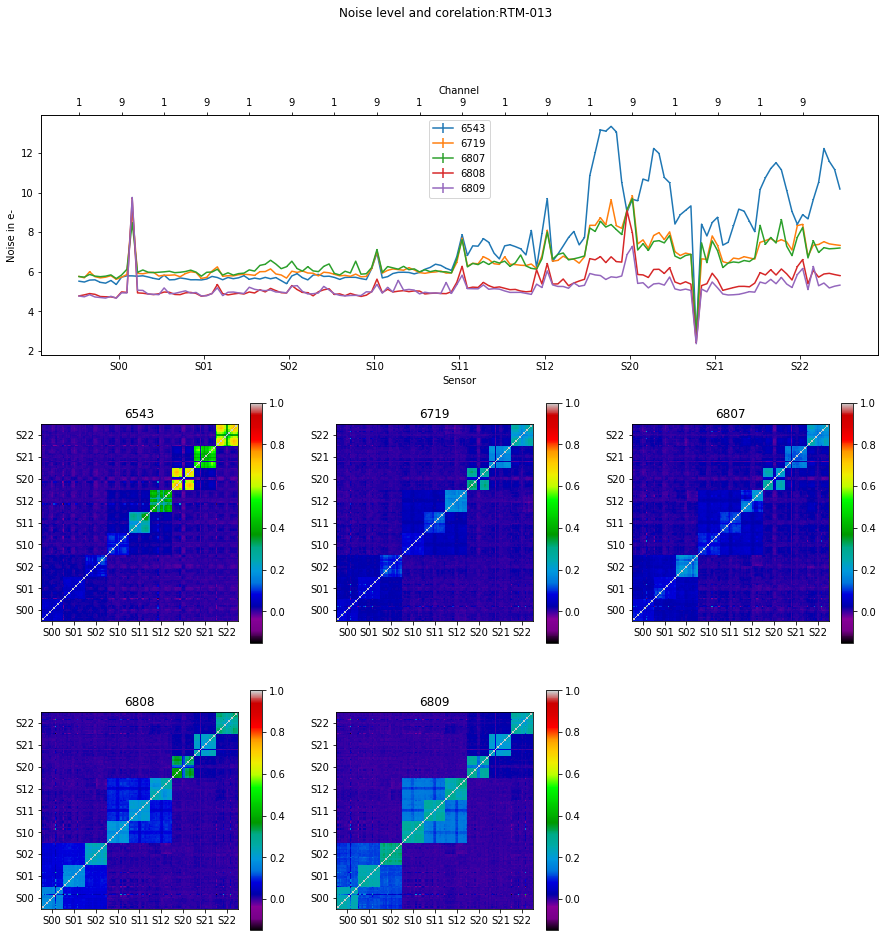

RTM-013_6543_6719_6807_6808_6809_all_noise.png


In [6]:
# compute the correlation between the # channels of the raft 
#
cornoise=np.zeros((number_of_run,144,144))
t0=time.time()
for irun in range(number_of_run) :
    if irun==0 :
        print('Computing correlations for run ',run_name_list[irun])
    else : 
        t1=time.time()
        print ('Computing correlations for run ',run_name_list[irun],'~',int((t1-t0)*(number_of_run-irun)/irun),' seconds left before the end of the processing of all the runs')
    for iccd in range(number_of_sensor) :
        for ch in range(16) :
            ff=all_file[irun,iccd]
            ch_cur=16*iccd+ch
            mean_over[irun,ch_cur]=ff[ch+1].data[100:1900,first_s_over+2:].mean(axis=1)
            #if ch_cur%20==0 : print(ch_cur,' raft channels processed among 144')
            for iccd1 in range(number_of_sensor) :
                for ch1 in range(16) :
                    ch_cur1=16*iccd1+ch1
                    if ch_cur1 > ch_cur : continue
                    ff1=all_file[irun,iccd1]
                    cornoise[irun,ch_cur,ch_cur1]=np.array([(ff[ch+1].data[100:1900,i]-mean_over[irun,ch_cur][:])*gain[irun,iccd,ch]*(ff1[ch1+1].data[100:1900,i]-mean_over[irun,ch_cur1][:])*gain[irun,iccd1,ch1] for i in range(first_s_over+2,ncol) ]).mean() 
for irun in range(number_of_run) :
    for iccd in range(number_of_sensor) :
        for ch in range(16) :
            ch_cur=16*iccd+ch
            for iccd1 in range(number_of_sensor) :
                for ch1 in range(16) :
                    ch_cur1=16*iccd1+ch1
                    if ch_cur1 > ch_cur :
                        cornoise[irun,ch_cur,ch_cur1]=cornoise[irun,ch_cur1,ch_cur]
cor=np.zeros((number_of_run,144,144))
for irun in range(number_of_run) :
    for iccd in range(number_of_sensor) :
        for ch in range(16) :
            ch_cur=16*iccd+ch
            #print(np.sqrt(cornoise[irun,ch_cur,ch_cur]),noise[irun,ch_cur])
            for iccd1 in range(number_of_sensor) :
                for ch1 in range(16) :
                    ch_cur1=16*iccd1+ch1
                    cor[irun,ch_cur,ch_cur1]=cornoise[irun,ch_cur,ch_cur1]/np.sqrt(cornoise[irun,ch_cur,ch_cur]*cornoise[irun,ch_cur1,ch_cur1])
# labels for the plots
label_txt=np.zeros((9),dtype=np.object_)
label_pos=np.zeros((9))
label_chan=np.zeros((18),dtype=np.object_)
label_chan_pos=np.zeros((18))
for  iccd in range(9) : 
        s=sensor_list[iccd]
        label_txt[iccd]=s
        label_pos[iccd]=iccd*16+7.5
        label_chan[iccd*2]='%d' % (1)
        label_chan[iccd*2+1]='%d' % (9)
        label_chan_pos[iccd*2]=iccd*16
        label_chan_pos[iccd*2+1]=iccd*16+8
# go for the plots
fig=plt.figure(figsize=[15,15])
fig.suptitle('Noise level and corelation:'+data_to_select['RTM'])

ax1=fig.add_subplot(3,1,1)
ax2=ax1.twiny()
#plt.tick_params(axis='x',top='on',labeltop='on')
#,bottom='off',labelbottom='off')
#
for irun in range(number_of_run) :
    ax1.errorbar(range(144),noise[irun,:],yerr=noise_std[irun,:],label=run_name_list[irun])
ax1.legend(loc=9)
if display_in_electron and eotest_db :
    ax1.set_ylabel('Noise in e-')
else :
    ax1.set_ylabel('Noise in ADU')
ax1.set_xlabel('Sensor')
ax1.set_xticks(label_pos)
ax1.set_xticklabels(label_txt)
ax2.set_xlim(ax1.get_xlim())
ax2.tick_params(labeltop='on')
ax2.set_xticks(label_chan_pos)
ax2.set_xticklabels(label_chan)
plt.xlabel('Channel')
title=''
loc=3
for irun in range(number_of_run) :
    loc+=1
    if loc>9 : 
        plt.show()
        plotfile=data_to_select['RTM']+title+'_all_noise.png'
        print (plotfile)
        fig.savefig(plotfile,bbox_inches='tight')
        loc=1
        title=''
        fig=plt.figure(figsize=[15,15])
        fig.suptitle('Noise level and corelation:'+data_to_select['RTM'])
    title+='_'+run_name_list[irun]
    fig.add_subplot(3,3,loc,title=run_name_list[irun])
    plt.imshow(cor[irun,:,:],cmap=matplotlib.cm.nipy_spectral,shape=(144,144),origin='lower',vmin=-.15,vmax=1.)
    plt.xticks(label_pos,label_txt)
    plt.yticks(label_pos,label_txt)
    plt.colorbar()
          
    #plt.show()
plt.show()
plotfile=data_to_select['RTM']+title+'_all_noise.png'
print (plotfile)
fig.savefig(plotfile,bbox_inches='tight')